In [1]:
import kagglehub
import yfinance as yf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd
import yfinance as yf
import time

# Define the path to the CSV file
csv_file_path = 'resources/sp500_data.csv'

# Check if the CSV file already exists
if os.path.exists(csv_file_path):
    # Load the data from the CSV file
    data = pd.read_csv(csv_file_path)
    print("Data loaded from CSV file.")
else:
    # Download the latest version of the dataset
    path = kagglehub.dataset_download("andrewmvd/sp-500-stocks")

    # Print the path to the dataset directory
    print("Path to dataset files:", path)

    # List all files in the dataset directory
    files = os.listdir(path)
    print("Files in the dataset directory:", files)

    # Dynamically select the first file (assuming there's only one dataset file)
    dataset_file = os.path.join(path, files[1])  # Using the first file
    print("Dataset file selected:", dataset_file)

    # Load the dataset into a DataFrame
    df = pd.read_csv(dataset_file)

    # Extract the list of tickers
    tickers = list(df['Symbol'][:500])  # Adjust slice as needed
    print(f"Tickers extracted ({len(tickers)}): {tickers}")

    # Initialize the indicators
    indicators = [
        "debtToEquityRatio", "profitMargins", "returnOnEquity", "returnOnAssets", "freeCashFlow",
        "revenueGrowth", "earningsGrowth", "operatingMargins", "dividendRate", "dividendYield",
        "payoutRatio", "trailingPE", "forwardPE", "priceToSalesRatio", "marketCap",
        "enterpriseValue", "recommendationMean", "targetMeanPrice"
    ]

    # Initialize an empty list to collect ticker data
    ticker_data_list = []

    # Fetch data for each ticker and populate the DataFrame
    for ticker in tickers:
        try:
            print(f"Fetching data for {ticker}...")
            stock = yf.Ticker(ticker)
            info = stock.info  # Fetch company info

            # Create a dictionary for the current ticker's data
            ticker_data = {"ticker": ticker}
            for ind in indicators:
                ticker_data[ind] = info.get(ind)
            
            # Append the dictionary to the list
            ticker_data_list.append(ticker_data)
            time.sleep(0.5)  # Add a delay to avoid API rate limits
        except Exception as e:
            print(f"Failed to fetch data for {ticker}: {e}")

    # Convert the list of dictionaries into a DataFrame
    data = pd.DataFrame(ticker_data_list)

    # Ensure numeric columns
    for col in indicators:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

    # Save the data to a CSV file
    os.makedirs('resources', exist_ok=True)
    data.to_csv(csv_file_path, index=False)
    print("Data saved to CSV file.")

# Display the resulting raw DataFrame
print("Raw Extracted Data:")
print(data.head())

Data loaded from CSV file.
Raw Extracted Data:
  ticker  debtToEquityRatio  profitMargins  returnOnEquity  returnOnAssets  \
0   AAPL                NaN        0.23971         1.57413         0.21464   
1   NVDA                NaN        0.55041         1.23767         0.55258   
2   MSFT                NaN        0.35608         0.35604         0.14592   
3   AMZN                NaN        0.08042         0.22558         0.07069   
4  GOOGL                NaN        0.27738         0.32101         0.16483   

   freeCashFlow  revenueGrowth  earningsGrowth  operatingMargins  \
0           NaN          0.061          -0.341           0.31171   
1           NaN          1.224           1.680           0.62057   
2           NaN          0.160           0.104           0.46584   
3           NaN          0.110           0.521           0.10959   
4           NaN          0.151           0.366           0.32312   

   dividendRate  dividendYield  payoutRatio  trailingPE  forwardPE  \
0    

In [3]:
# Threshold for dropping columns: more than 30% NaN
threshold = 0.3

# Identify columns to drop
cols_to_drop = data.columns[data.isna().mean() > threshold]

# Drop columns in place
data.drop(columns=cols_to_drop, inplace=True)

# Print the dropped columns
print("Columns dropped:", cols_to_drop.tolist())
print("Remaining columns:", data.columns.tolist())

Columns dropped: ['debtToEquityRatio', 'freeCashFlow', 'priceToSalesRatio']
Remaining columns: ['ticker', 'profitMargins', 'returnOnEquity', 'returnOnAssets', 'revenueGrowth', 'earningsGrowth', 'operatingMargins', 'dividendRate', 'dividendYield', 'payoutRatio', 'trailingPE', 'forwardPE', 'marketCap', 'enterpriseValue', 'recommendationMean', 'targetMeanPrice']


In [4]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import matplotlib.pyplot as plt

# Define available indicators (removing the dropped columns)
indicators = [
    "profitMargins", "returnOnEquity", "returnOnAssets",
    "revenueGrowth", "earningsGrowth", "operatingMargins", "dividendRate", 
    "dividendYield", "payoutRatio", "trailingPE", "forwardPE", "marketCap",
    "enterpriseValue", "recommendationMean", "targetMeanPrice"
]

In [5]:
def handle_outliers(df, columns, method="cap"):
    """
    Handle outliers in the specified columns of a DataFrame.
    """
    df_cleaned = df.copy()
    for col in columns:
        if col in df_cleaned.columns:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
            
            if df_cleaned[col].isna().all():
                print(f"Skipping column '{col}' as it contains all NaN values.")
                continue
            
            q1 = df_cleaned[col].quantile(0.25)
            q3 = df_cleaned[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            if method == "remove":
                df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & 
                                      (df_cleaned[col] <= upper_bound)]
            elif method == "cap":
                df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
    return df_cleaned

def preprocess_data(data):
    """
    Preprocess the data including handling outliers and creating interaction features.
    """
    data_cleaned = data.copy()
    
    # Print available columns for debugging
    print("Available columns:", data_cleaned.columns.tolist())
    
    # Create interaction features from existing data
    data_cleaned['profit_growth'] = data_cleaned['profitMargins'] * data_cleaned['revenueGrowth']
    data_cleaned['dividend_strength'] = data_cleaned['dividendYield'] * data_cleaned['payoutRatio']
    data_cleaned['value_metric'] = data_cleaned['trailingPE'] * data_cleaned['marketCap']
    
    # Handle outliers for all numeric columns
    numeric_columns = data_cleaned.select_dtypes(include=[np.number]).columns
    data_cleaned = handle_outliers(data_cleaned, numeric_columns, method="cap")
    
    # Handle missing values
    for col in numeric_columns:
        median_val = data_cleaned[col].median()
        data_cleaned[col] = data_cleaned[col].fillna(median_val)
    
    return data_cleaned

In [6]:
def engineer_features(data):
    """
    Engineer features for the model.
    """
    # Use only confirmed existing features
    indicators = [
        "profitMargins", "returnOnEquity", "returnOnAssets",
        "revenueGrowth", "operatingMargins", "dividendYield",
        "trailingPE", "marketCap", "recommendationMean",
        "profit_growth", "dividend_strength", "value_metric"
    ]
    
    features = pd.DataFrame()
    for ind in indicators:
        if ind in data.columns:
            features[ind] = data[ind]
        else:
            print(f"Warning: {ind} not found in data")
    
    return features

def create_ensemble_model():
    """
    Create an ensemble model combining XGBoost, LightGBM, and Random Forest.
    """
    base_models = [
        ('xgb', XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )),
        ('lgb', lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            random_state=42
        )),
        ('rf', RandomForestRegressor(
            n_estimators=200,
            max_depth=6,
            random_state=42
        ))
    ]
    
    return VotingRegressor(estimators=base_models)

In [7]:
def run_enhanced_model(data):
    """
    Run the enhanced model pipeline including preprocessing, training, and evaluation.
    """
    # Preprocess data
    data_cleaned = preprocess_data(data)
    
    # Engineer features
    X = engineer_features(data_cleaned)
    y = data_cleaned["targetMeanPrice"]
    
    # Scale features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Time series split
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Create and train ensemble model
    model = create_ensemble_model()
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=tscv, 
                              scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    # Train final model
    model.fit(X_scaled, y)
    
    # Generate predictions
    predictions = model.predict(X_scaled)
    
    # Calculate metrics
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    
    # Calculate directional accuracy
    directional_accuracy = np.mean(
        (predictions[1:] > predictions[:-1]) == (y.values[1:] > y.values[:-1])
    )
    
    # Store results
    results = {
        'model': model,
        'predictions': predictions,
        'features': X,  # Store features for later use
        'metrics': {
            'r2': r2,
            'mae': mae,
            'rmse': rmse,
            'cv_rmse_mean': rmse_scores.mean(),
            'cv_rmse_std': rmse_scores.std(),
            'directional_accuracy': directional_accuracy
        }
    }
    
    # Add scores to original data
    data_cleaned['model_score'] = predictions
    data_cleaned['score'] = (predictions - predictions.min()) / (predictions.max() - predictions.min()) * 10
    
    return data_cleaned, results

Available columns: ['ticker', 'profitMargins', 'returnOnEquity', 'returnOnAssets', 'revenueGrowth', 'earningsGrowth', 'operatingMargins', 'dividendRate', 'dividendYield', 'payoutRatio', 'trailingPE', 'forwardPE', 'marketCap', 'enterpriseValue', 'recommendationMean', 'targetMeanPrice']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 12
[LightGBM] [Info] Start training from score 264.012490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

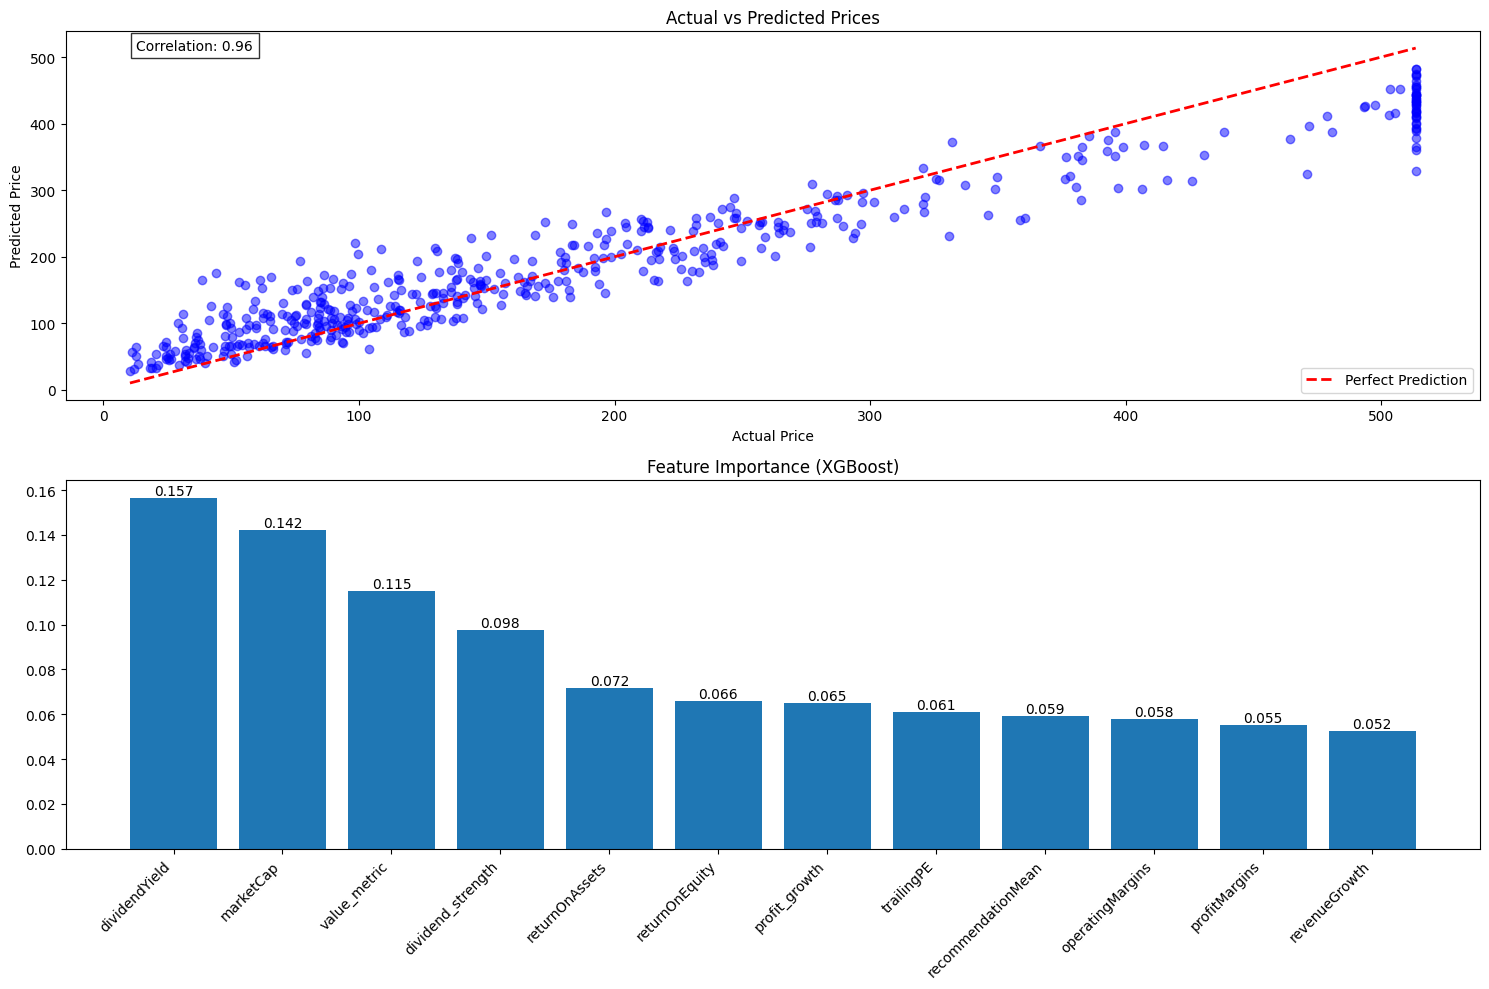

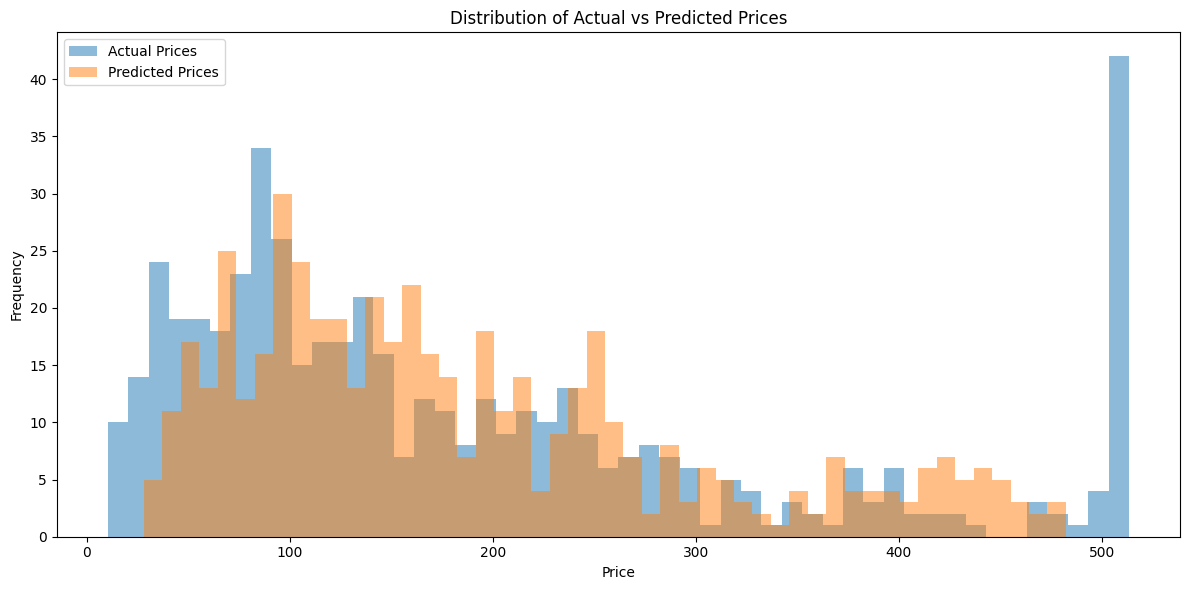

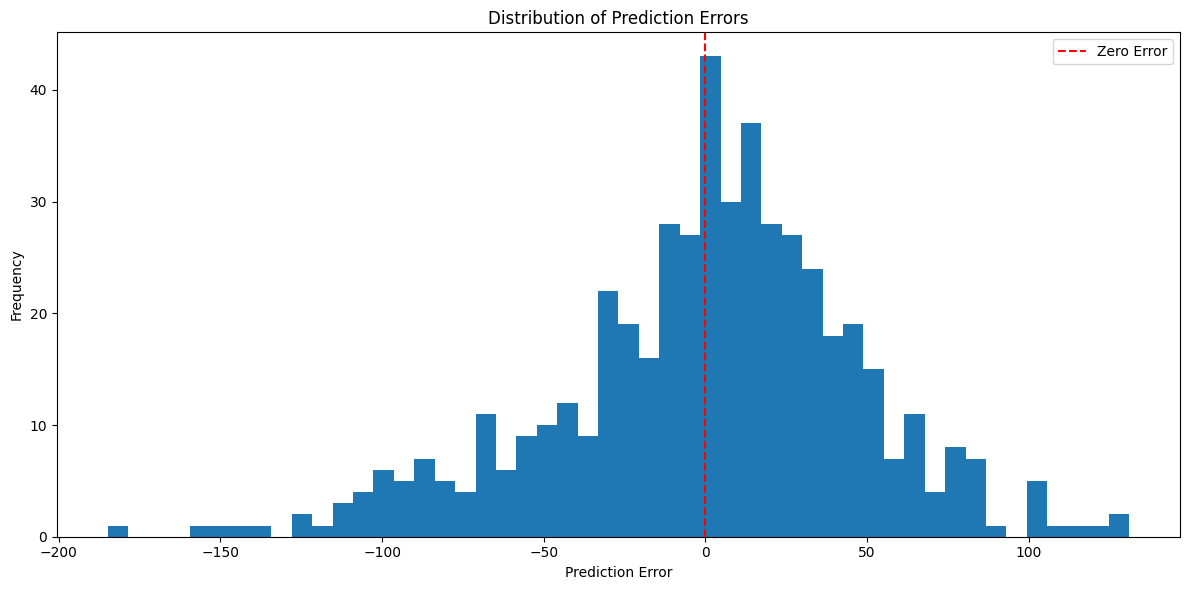


Error Statistics:
Mean Error: 0.04
Median Error: 3.82
Standard Deviation of Error: 48.10
Mean Absolute Error: 36.36
Predictions within 5.0% of actual price: 15.8%
Predictions within 10.0% of actual price: 30.2%
Predictions within 20.0% of actual price: 57.0%


In [8]:
# Execute the enhanced model
data_cleaned, results = run_enhanced_model(data)

# Print results
print("\nModel Performance Metrics:")
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

# Display top stocks
top_stocks = data_cleaned[['ticker', 'score', 'model_score', 'targetMeanPrice']].sort_values('score', ascending=False).head(10)
print("\nTop 10 Stocks by Model Score:")
print(top_stocks)

# Create figure with subplots
plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted Scatter Plot
plt.subplot(2, 1, 1)
plt.scatter(data_cleaned['targetMeanPrice'], results['predictions'], alpha=0.5, c='blue')
plt.plot([data_cleaned['targetMeanPrice'].min(), data_cleaned['targetMeanPrice'].max()], 
         [data_cleaned['targetMeanPrice'].min(), data_cleaned['targetMeanPrice'].max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()

# Add correlation coefficient
correlation = np.corrcoef(data_cleaned['targetMeanPrice'], results['predictions'])[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

# 2. Feature Importance Plot
plt.subplot(2, 1, 2)
model = results['model']
xgb_model = model.named_estimators_['xgb']
importance_df = pd.DataFrame({
    'Feature': results['features'].columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
bars = plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance (XGBoost)')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional Analysis: Price Range Distribution
plt.figure(figsize=(12, 6))
plt.hist(data_cleaned['targetMeanPrice'], bins=50, alpha=0.5, label='Actual Prices')
plt.hist(results['predictions'], bins=50, alpha=0.5, label='Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted Prices')
plt.legend()
plt.tight_layout()
plt.show()

# Error Analysis
errors = results['predictions'] - data_cleaned['targetMeanPrice']
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.legend()
plt.tight_layout()
plt.show()

# Print additional statistics
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.2f}")
print(f"Median Error: {np.median(errors):.2f}")
print(f"Standard Deviation of Error: {errors.std():.2f}")
print(f"Mean Absolute Error: {np.abs(errors).mean():.2f}")

# Calculate percentage of predictions within different error ranges
error_ranges = [0.05, 0.10, 0.20]
for range_pct in error_ranges:
    within_range = np.mean(np.abs(errors / data_cleaned['targetMeanPrice']) < range_pct)
    print(f"Predictions within {range_pct*100}% of actual price: {within_range*100:.1f}%")

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def evaluate_window_performance(y_true, y_pred):
    """
    Comprehensive evaluation metrics for financial predictions
    """
    # Directional accuracy
    direction_true = np.diff(y_true) > 0
    direction_pred = np.diff(y_pred) > 0
    directional_accuracy = np.mean(direction_true == direction_pred) * 100
    
    # Traditional metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Combined score (weighted average)
    combined_score = (
        0.4 * directional_accuracy +  # Emphasis on direction
        0.3 * (100 * r2) +           # Scaled R²
        0.3 * (100 * (1 - rmse/np.mean(y_true)))  # Normalized RMSE
    )
    
    return {
        'directional_accuracy': directional_accuracy,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'combined_score': combined_score
    }

In [10]:
def grid_search_rolling_windows(X, y, window_sizes, step_sizes):
    """
    Perform grid search over rolling window parameters using multiple metrics.
    """
    best_score = -np.inf
    best_params = None
    results_summary = []

    for window_size in window_sizes:
        for step_size in step_sizes:
            all_predictions = []
            all_actuals = []

            # Rolling window loop
            for start_idx in range(0, len(X) - window_size, step_size):
                train_idx = range(start_idx, start_idx + window_size)
                test_start = start_idx + window_size
                test_end = min(test_start + step_size, len(X))
                test_idx = range(test_start, test_end)

                if len(test_idx) == 0:
                    continue

                # Split and train
                X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
                X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

                model = make_pipeline(
                    StandardScaler(), 
                    RandomForestRegressor(n_estimators=100, random_state=42)
                )
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)

                all_predictions.extend(predictions)
                all_actuals.extend(y_test.values)

            # Evaluate using multiple metrics
            if len(all_actuals) > 0:
                metrics = evaluate_window_performance(all_actuals, all_predictions)
                results_summary.append((
                    window_size, 
                    step_size, 
                    metrics['combined_score'],
                    metrics['directional_accuracy'],
                    metrics['r2'],
                    metrics['rmse']
                ))
                
                print(f"Window: {window_size}, Step: {step_size}, "
                      f"Combined Score: {metrics['combined_score']:.2f}, "
                      f"Dir Acc: {metrics['directional_accuracy']:.1f}%, "
                      f"R²: {metrics['r2']:.3f}")

                if metrics['combined_score'] > best_score:
                    best_score = metrics['combined_score']
                    best_params = (window_size, step_size)
                    best_predictions = all_predictions
                    best_actuals = all_actuals
                    best_metrics = metrics

    return best_params, best_metrics, results_summary, best_predictions, best_actuals

Window Size: 50, Step Size: 5, Overall R²: 0.0905
Window Size: 50, Step Size: 10, Overall R²: 0.0860
Window Size: 50, Step Size: 20, Overall R²: 0.1194
Window Size: 100, Step Size: 5, Overall R²: 0.1304
Window Size: 100, Step Size: 10, Overall R²: 0.1436
Window Size: 100, Step Size: 20, Overall R²: 0.0709
Window Size: 150, Step Size: 5, Overall R²: 0.0864
Window Size: 150, Step Size: 10, Overall R²: 0.0936
Window Size: 150, Step Size: 20, Overall R²: 0.1121

Best Parameters: Window Size = 100, Step Size = 10
Best Overall R²: 0.1436


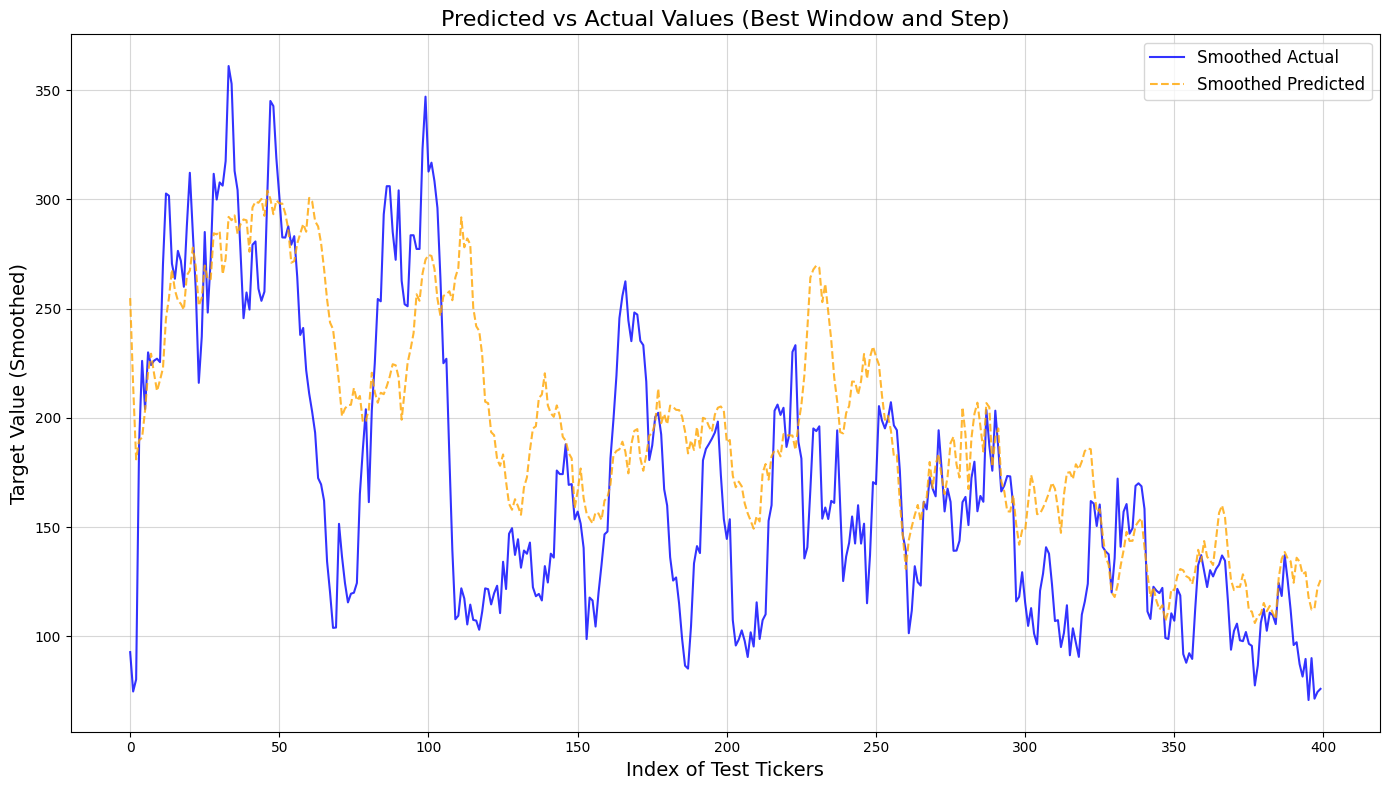

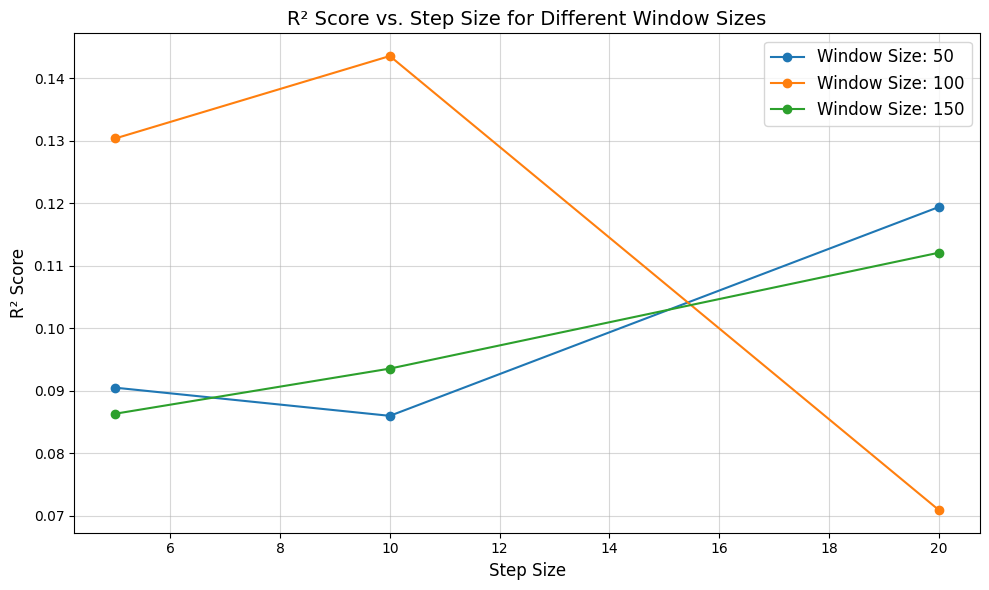

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def prepare_data_for_rolling_window(data):
    """
    Prepare data for rolling window analysis by selecting and preprocessing features.
    """
    # Select features (using the same features as our main model)
    features = [
        "profitMargins", "returnOnEquity", "returnOnAssets",
        "revenueGrowth", "operatingMargins", "dividendYield",
        "trailingPE", "marketCap", "recommendationMean"
    ]
    
    # Create X and y
    X = data[features].copy()
    y = data['targetMeanPrice']
    
    # Handle missing values
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    
    return X, y

def grid_search_rolling_windows(X, y, window_sizes, step_sizes):
    """
    Perform grid search over rolling window parameters.
    """
    best_r2 = -np.inf
    best_params = None
    results_summary = []

    for window_size in window_sizes:
        for step_size in step_sizes:
            all_predictions = []
            all_actuals = []

            # Rolling window loop
            for start_idx in range(0, len(X) - window_size, step_size):
                train_idx = range(start_idx, start_idx + window_size)
                test_start = start_idx + window_size
                test_end = min(test_start + step_size, len(X))
                test_idx = range(test_start, test_end)

                if len(test_idx) == 0:
                    continue

                # Split the data
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
                X_test = X.iloc[test_idx]
                y_test = y.iloc[test_idx]

                # Train the model
                model = make_pipeline(
                    StandardScaler(), 
                    RandomForestRegressor(n_estimators=100, random_state=42)
                )
                model.fit(X_train, y_train)

                # Predict on the test set
                predictions = model.predict(X_test)

                # Store predictions and actual values
                all_predictions.extend(predictions)
                all_actuals.extend(y_test.values)

            # Calculate R² for this parameter combination
            if len(all_actuals) > 0:
                overall_r2 = r2_score(all_actuals, all_predictions)
                results_summary.append((window_size, step_size, overall_r2))
                print(f"Window Size: {window_size}, Step Size: {step_size}, Overall R²: {overall_r2:.4f}")

                if overall_r2 > best_r2:
                    best_r2 = overall_r2
                    best_params = (window_size, step_size)
                    best_predictions = all_predictions
                    best_actuals = all_actuals

    return best_params, best_r2, results_summary, best_predictions, best_actuals

def plot_rolling_window_results(best_params, best_r2, results_summary, best_predictions, best_actuals, window_sizes):
    """
    Plot the results of the rolling window analysis.
    """
    # Create DataFrame for Actual and Predicted values
    results = pd.DataFrame({
        'Actual': best_actuals,
        'Predicted': best_predictions
    })

    # Apply smoothing using a rolling average
    results['Smoothed_Actual'] = results['Actual'].rolling(window=10, min_periods=1).mean()
    results['Smoothed_Predicted'] = results['Predicted'].rolling(window=10, min_periods=1).mean()

    # Plot 1: Smoothed Actual vs Predicted
    plt.figure(figsize=(14, 8))
    plt.plot(results['Smoothed_Actual'], label='Smoothed Actual', color='blue', linewidth=1.5, alpha=0.8)
    plt.plot(results['Smoothed_Predicted'], label='Smoothed Predicted', linestyle='--', color='orange', linewidth=1.5, alpha=0.8)

    plt.title('Predicted vs Actual Values (Best Window and Step)', fontsize=16)
    plt.xlabel('Index of Test Tickers', fontsize=14)
    plt.ylabel('Target Value (Smoothed)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Plot 2: R² results
    results_df = pd.DataFrame(results_summary, columns=["Window Size", "Step Size", "R² Score"])
    plt.figure(figsize=(10, 6))
    for window_size in window_sizes:
        subset = results_df[results_df["Window Size"] == window_size]
        plt.plot(subset["Step Size"], subset["R² Score"], marker='o', label=f"Window Size: {window_size}")

    plt.title("R² Score vs. Step Size for Different Window Sizes", fontsize=14)
    plt.xlabel("Step Size", fontsize=12)
    plt.ylabel("R² Score", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Execute the analysis
def run_rolling_window_analysis(data):
    """
    Run the complete rolling window analysis.
    """
    # Prepare data
    X, y = prepare_data_for_rolling_window(data)
    
    # Define window and step sizes
    # Window sizes: cover short, medium, and long-term patterns
    window_sizes = [50, 100, 150]  # approximately 2 months, 4 months, 6 months of trading days

    # Step sizes: balance between granularity and computation speed
    step_sizes = [5, 10, 20]  # weekly, bi-weekly, monthly steps
    
    # Run grid search
    best_params, best_r2, results_summary, best_predictions, best_actuals = grid_search_rolling_windows(
        X, y, window_sizes, step_sizes
    )
    
    # Display results
    print(f"\nBest Parameters: Window Size = {best_params[0]}, Step Size = {best_params[1]}")
    print(f"Best Overall R²: {best_r2:.4f}")
    
    # Plot results
    plot_rolling_window_results(
        best_params, best_r2, results_summary, 
        best_predictions, best_actuals, window_sizes
    )
    
    return {
        'best_params': best_params,
        'best_r2': best_r2,
        'predictions': best_predictions,
        'actuals': best_actuals
    }

# Run the analysis
rolling_window_results = run_rolling_window_analysis(data_cleaned)


Model Performance Metrics:
Directional Accuracy: 86.6%
Model Grade: A - Excellent


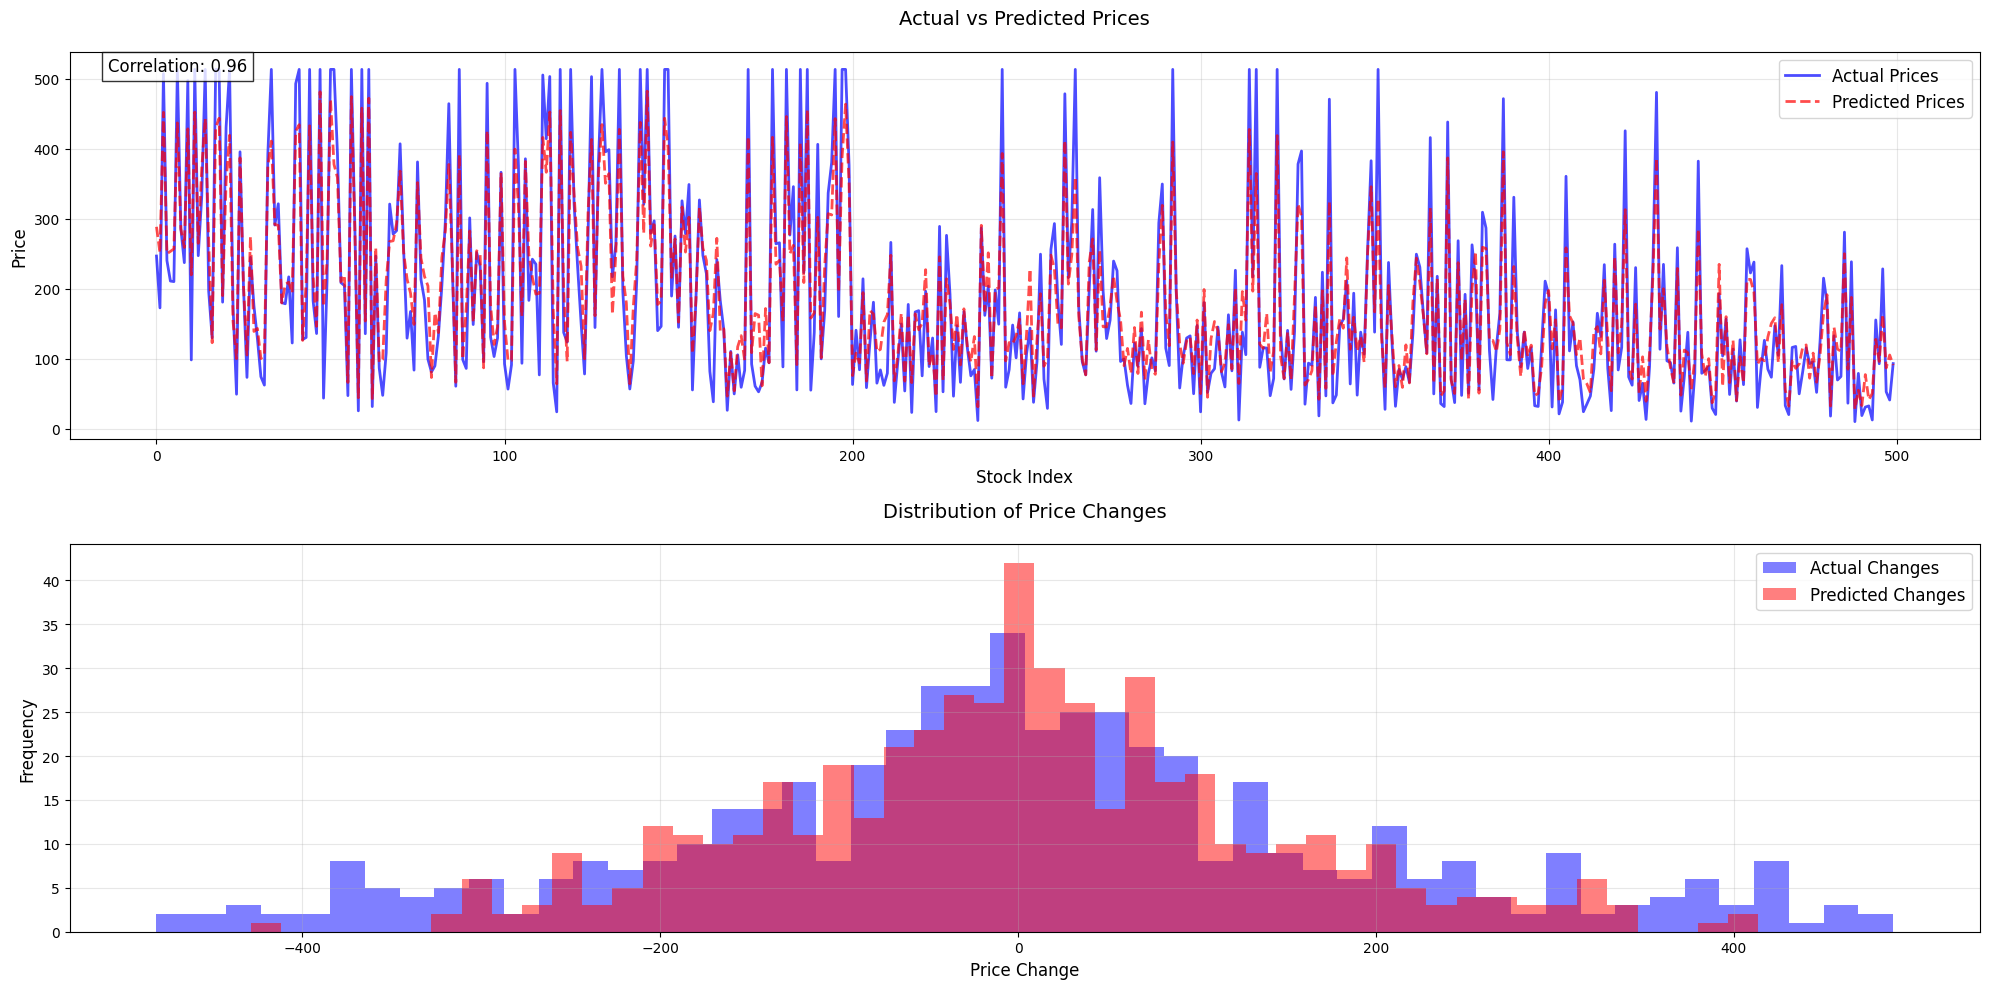


Additional Metrics:
RMSE: 48.06
MAE: 36.36
Correlation: 0.96


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance(data_cleaned, results):
    """
    Evaluate model performance focusing on directional accuracy and price predictions
    """
    # Calculate directional accuracy
    actual_changes = np.diff(data_cleaned['targetMeanPrice'])
    predicted_changes = np.diff(results['predictions'])
    
    directional_accuracy = np.mean(
        (actual_changes > 0) == (predicted_changes > 0)
    ) * 100
    
    # Grade the model based on directional accuracy
    def get_grade(accuracy):
        if accuracy >= 70:
            return "A - Excellent"
        elif accuracy >= 65:
            return "B - Good" 
        elif accuracy >= 60:
            return "C - Fair"
        elif accuracy >= 55:
            return "D - Poor"
        else:
            return "F - Failing"
            
    grade = get_grade(directional_accuracy)
    
    # Print performance metrics
    print("\nModel Performance Metrics:")
    print("=========================")
    print(f"Directional Accuracy: {directional_accuracy:.1f}%")
    print(f"Model Grade: {grade}")
    
    # Create visualizations
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Actual vs Predicted Prices with better formatting
    plt.subplot(2, 1, 1)
    
    # Create index for x-axis
    x = range(len(data_cleaned))
    
    # Plot with increased line width and different colors
    plt.plot(x, data_cleaned['targetMeanPrice'], 
             label='Actual Prices', 
             color='blue',
             linewidth=2,
             alpha=0.7)
    
    plt.plot(x, results['predictions'], 
             label='Predicted Prices', 
             color='red',
             linewidth=2,
             alpha=0.7,
             linestyle='--')
    
    # Improve formatting
    plt.title('Actual vs Predicted Prices', fontsize=14, pad=20)
    plt.xlabel('Stock Index', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    correlation = np.corrcoef(data_cleaned['targetMeanPrice'], results['predictions'])[0,1]
    plt.text(0.02, 0.95, f'Correlation: {correlation:.2f}', 
             transform=plt.gca().transAxes,
             fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot 2: Price Changes Distribution
    plt.subplot(2, 1, 2)
    plt.hist(actual_changes, bins=50, alpha=0.5, label='Actual Changes', color='blue')
    plt.hist(predicted_changes, bins=50, alpha=0.5, label='Predicted Changes', color='red')
    plt.title('Distribution of Price Changes', fontsize=14, pad=20)
    plt.xlabel('Price Change', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional error metrics
    mse = np.mean((data_cleaned['targetMeanPrice'] - results['predictions'])**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(data_cleaned['targetMeanPrice'] - results['predictions']))
    
    print("\nAdditional Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Correlation: {correlation:.2f}")
    
    return {
        'directional_accuracy': directional_accuracy,
        'grade': grade,
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation
    }

# Run the evaluation
model_evaluation = evaluate_model_performance(data_cleaned, results)

# DASH START

In [13]:
# Import required libraries
import openai
import dash
import dash_bootstrap_components as dbc 
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
from dotenv import load_dotenv
import os
from flask_caching import Cache

# Load environment variables and initialize OpenAI client
load_dotenv()
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Initialize the Dash app with Bootstrap
app = Dash(
    __name__,
    external_stylesheets=[dbc.themes.BOOTSTRAP],
    title="AI Investing Advisor"
)
server = app.server

# Configure caching
cache = Cache(app.server, config={
    "CACHE_TYPE": "filesystem",
    "CACHE_DIR": "cache-directory"
})

In [14]:
# Load data
csv_file_path = "resources/sp500_data.csv"
if os.path.exists(csv_file_path):
    data = pd.read_csv(csv_file_path)
    print("Data loaded from CSV file.")
else:
    raise FileNotFoundError(f"The file {csv_file_path} does not exist. Please provide the correct data file.")

# Scale the scores from data_cleaned
def scale_scores(scores):
    """Scale scores to range 0-10"""
    min_score = scores.min()
    max_score = scores.max()
    return ((scores - min_score) / (max_score - min_score)) * 10

# Add the scaled composite score using data_cleaned's score
data['composite_score'] = scale_scores(data_cleaned['score'])

Data loaded from CSV file.


In [15]:
# Create sidebar
sidebar = html.Div(
    [
        dbc.Row(
            [
                html.H2("AI Investing", className="sidebar-title"),
                html.H4("Advisor", className="sidebar-subtitle"),
            ],
            className="sidebar-header",
        ),
        html.Hr(),
        dbc.Nav(
            [
                dbc.NavLink(
                    [html.I(className="fas fa-chart-line me-2"), "Stock Analysis"],
                    href="#",
                    active="exact",
                    className="nav-link"
                ),
                dbc.NavLink(
                    [html.I(className="fas fa-robot me-2"), "AI Recommendations"],
                    href="#",
                    active="exact",
                    className="nav-link"
                ),
                dbc.NavLink(
                    [html.I(className="fas fa-chart-pie me-2"), "Portfolio Insights"],
                    href="#",
                    active="exact",
                    className="nav-link"
                ),
            ],
            vertical=True,
            pills=True,
        ),
        html.Div(
            [
                html.Span("Powered by "),
                html.A("OpenAI", href="https://openai.com", target="_blank"),
                html.Br(),
                html.Span("Data Source: "),
                html.A("S&P 500", href="#", target="_blank"),
            ],
            className="sidebar-footer",
        ),
    ],
    className="sidebar",
)

In [16]:
# Main content with composite score section
content = html.Div(
    [
        dbc.Container(
            [
                # Top Stocks Section
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.H4("Top Rated Stocks", className="analysis-header"),
                                html.Div(id="top-stocks", className="analysis-content shadow-sm"),
                            ],
                            width=12,
                        ),
                    ],
                    className="mb-4"
                ),
                # Stock Selection Section
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.Label("Select Stocks to Compare:", className="label"),
                                dcc.Dropdown(
                                    id="ticker-dropdown",
                                    options=[{"label": ticker, "value": ticker} for ticker in data["ticker"].unique()],
                                    multi=True,
                                    placeholder="Select stocks to analyze...",
                                    className="dropdown"
                                ),
                            ],
                            width=6,
                        ),
                        dbc.Col(
                            [
                                html.Label("Select Financial Metric:", className="label"),
                                dcc.Dropdown(
                                    id="indicator-dropdown",
                                    options=[
                                        {"label": "AI Composite Score", "value": "composite_score"},
                                        {"label": "Profit Margins", "value": "profitMargins"},
                                        {"label": "Return on Equity", "value": "returnOnEquity"},
                                        {"label": "Dividend Yield", "value": "dividendYield"},
                                        {"label": "Revenue Growth", "value": "revenueGrowth"},
                                    ],
                                    placeholder="Choose a metric...",
                                    className="dropdown"
                                ),
                            ],
                            width=6,
                        ),
                    ],
                    className="mb-4"
                ),
                # Graph Section
                dbc.Row(
                    [
                        dbc.Col(
                            dcc.Graph(id="indicator-graph", className="shadow-sm"),
                            width=12,
                        ),
                    ]
                ),
                # AI Analysis Section
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.H4("AI Analysis", className="analysis-header"),
                                html.Div(
                                    id="ai-analysis",
                                    className="analysis-content shadow-sm"
                                ),
                            ],
                            width=12,
                        ),
                    ],
                    className="mt-4"
                ),
            ],
            fluid=True,
        ),
    ],
    className="content"
)

In [17]:
# Callback for top stocks display
@app.callback(
    Output("top-stocks", "children"),
    [Input("indicator-dropdown", "value")]  # Updates when metric changes
)
def update_top_stocks(_):
    top_5 = data.nlargest(5, 'composite_score')
    return html.Div([
        dbc.Row([
            dbc.Col([
                html.Div([
                    html.H5(row['ticker'], className="mb-0"),
                    html.P(f"Score: {row['composite_score']:.1f}/10", className="mb-0"),
                ], className="stock-card")
            ], width=2)
            for _, row in top_5.iterrows()
        ])
    ])

# Callback for the graph
@app.callback(
    Output("indicator-graph", "figure"),
    [Input("ticker-dropdown", "value"),
     Input("indicator-dropdown", "value")]
)
def update_graph(selected_tickers, selected_indicator):
    if not selected_tickers or not selected_indicator:
        return px.bar(title="Select tickers and indicator to display the graph")

    filtered_data = data[data["ticker"].isin(selected_tickers)]
    fig = px.bar(filtered_data, x="ticker", y=selected_indicator, color="ticker",
                 title=f"{selected_indicator} for Selected Tickers")
    
    # Add reference line for composite score
    if selected_indicator == "composite_score":
        fig.add_hline(y=5, line_dash="dash", line_color="gray",
                     annotation_text="Average Score")
    
    fig.update_layout(
        template="plotly_white",
        title_x=0.5,
        margin=dict(t=50, l=0, r=0, b=0),
        yaxis_title=selected_indicator.replace("_", " ").title(),
        xaxis_title="Ticker",
        showlegend=True,
        legend_title_text="Stocks"
    )
    return fig

# Callback for AI analysis
@app.callback(
    Output("ai-analysis", "children"),
    [Input("ticker-dropdown", "value"),
     Input("indicator-dropdown", "value")]
)
def generate_ai_analysis(selected_tickers, selected_indicator):
    if not selected_tickers:
        return "Please select at least one stock to analyze."
    if not selected_indicator:
        return "Please select a financial metric to analyze."

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a professional financial advisor providing clear, concise stock insights."},
                {"role": "user", "content": f"Analyze these stocks: {', '.join(selected_tickers)} based on {selected_indicator}. Provide key insights and recommendations."}
            ],
            max_tokens=200,
            temperature=0.7
        )
        return html.Div([
            html.P(response.choices[0].message.content.strip())
        ])
    except Exception as e:
        return f"Unable to generate analysis at this time: {str(e)}"

In [18]:
# Custom CSS
app.index_string = """
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        {%css%}
        <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0/css/all.min.css">
        <style>
            .sidebar {
                position: fixed;
                top: 0;
                left: 0;
                bottom: 0;
                width: 250px;
                padding: 2rem 1rem;
                background-color: #2c3e50;
                color: white;
            }
            .sidebar-header {
                text-align: center;
                margin-bottom: 2rem;
            }
            .sidebar-title {
                color: white;
                margin: 0;
                font-size: 1.5rem;
            }
            .sidebar-subtitle {
                color: #3498db;
                margin: 0;
                font-size: 1.2rem;
            }
            .nav-link {
                color: #ecf0f1 !important;
                margin: 0.5rem 0;
            }
            .nav-link:hover {
                background-color: #34495e !important;
            }
            .nav-link.active {
                background-color: #3498db !important;
            }
            .sidebar-footer {
                position: absolute;
                bottom: 1rem;
                left: 1rem;
                right: 1rem;
                font-size: 0.8rem;
                color: #bdc3c7;
            }
            .content {
                margin-left: 250px;
                padding: 2rem;
            }
            .label {
                font-weight: 600;
                margin-bottom: 0.5rem;
            }
            .dropdown {
                margin-bottom: 1rem;
            }
            .analysis-header {
                color: #2c3e50;
                margin-bottom: 1rem;
            }
            .analysis-content {
                background-color: white;
                padding: 1.5rem;
                border-radius: 0.5rem;
            }
            .shadow-sm {
                box-shadow: 0 .125rem .25rem rgba(0,0,0,.075)!important;
            }
            .stock-card {
                background-color: white;
                padding: 1rem;
                border-radius: 0.5rem;
                box-shadow: 0 .125rem .25rem rgba(0,0,0,.075);
                text-align: center;
                margin-bottom: 1rem;
            }
            .stock-card h5 {
                color: #2c3e50;
                font-weight: 600;
            }
            .stock-card p {
                color: #3498db;
                font-size: 0.9rem;
            }
        </style>
    </head>
    <body>
        {%app_entry%}
        {%config%}
        {%scripts%}
        {%renderer%}
    </body>
</html>
"""

# Layout
app.layout = html.Div([sidebar, content])

In [21]:
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)  # Changed port to 8051

# Now incorporate the composite scores with Data Visualization and the Dash App to better inform an investor
### Also, need to increase Directional accuracy and Magnitude Accuracy 